In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from datetime import datetime

style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline  

# Hypothesis

Our price trend for property listing on Propwall is showing a decreasing trend, however, NAPIC MHPI is showing an upward trend.

We think that is due to the lack of control on market baskets on our Propwall analysis. We hypothesize that we may be able to shed some light if we discover market baskets in 2013 (start of Propwall data set)

For this exercise/analysis, let's focus on Kuala Lumpur.

## Key Steps

1. Breakdown Kuala Lumpur into areas based on Parlimentary boundaries (reason being that this is the most proper breakdown we can get)
2. Breakdown by Condominiums / Highrises
3. Breakdown by the cost of property listing. Obtain the threshold by comparing to income level / external sources
4. Find the number of property listing in each 'basket'. This is the number of observation to be sampled in the following years.
5. Plot the price based on these basket weights

## Creating the Dataset

In [2]:
# Load Property listing data 
df_sales = pd.read_csv('../data/processed/Propwall_Report_ForSale-28-3-18.csv')
# Load Property to District mapping
df_district = pd.read_excel('../data/external/kl_sel_districted.xlsx')
# Join the two set using Location_property as key
df_sales = df_sales.join(df_district, on='Location_property')
df_sales

Unnamed: 0         Type                            Location  \
0                0  Condominium                                 NaN   
1                9        House           Kuchai Lama, Kuala Lumpur   
2               21        House                  Teluk Intan, Perak   
3               22  Condominium                                 NaN   
4               33  Condominium        Ara Damansara, Petaling Jaya   
5               37  Condominium              Tanjung Tokong, Penang   
6               49  Condominium                  TTDI, Kuala Lumpur   
7               53  Condominium                                 NaN   
8               95  Condominium                                 NaN   
9              103  Condominium                                 NaN   
10             106  Condominium                                 NaN   
11             107  Condominium                                 NaN   
12             109  Condominium                                 NaN   
13             115  Condominium                                 NaN   
14             117        House                                 NaN   
15             121  Condominium            Tropicana, Petaling Jaya   
16             127  Condominium                                 NaN   
17             129  Condominium                Kota Kinabalu, Sabah   
18             149  Condominium                                 NaN   
19             156  Condominium                                 NaN   
20             158  Condominium                                 NaN   
21             162  Condominium                                 NaN   
22             171  Condominium                                 NaN   
23             172  Condominium                                 NaN   
24             173  Condominium                                 NaN   
25             176  Condominium                                 NaN   
26             191        House                  Teluk Intan, Perak   
27             192        House                Batu Caves, Selangor   
28             202        House           Genting Highlands, Pahang   
29             206  Condominium           Setiawangsa, Kuala Lumpur   
...            ...          ...                                 ...   
559630     4488350  Condominium                                 NaN   
559631     4488354  Condominium                                 NaN   
559632     4488364        House      Bukit Mertajam, Seberang Perai   
559633     4488398  Condominium                                 NaN   
559634     4488414  Condominium                                 NaN   
559635     4488435        House                                 NaN   
559636     4488439        House                                 NaN   
559637     4488441        House                                 NaN   
559638     4488473        House                                 NaN   
559639     4488474        House      Bukit Mertajam, Seberang Perai   
559640     4488483  Condominium                                 NaN   
559641     4488488  Condominium  Bandar Damai Perdana, Cheras South   
559642     4488495        House                                 NaN   
559643     4488502  Condominium                                 NaN   
559644     4488526  Condominium                                 NaN   
559645     4488531  Condominium                                 NaN   
559646     4488542  Condominium                                 NaN   
559647     4488562  Condominium                                 NaN   
559648     4488566        House                                 NaN   
559649     4488581        House  Bandar Damai Perdana, Cheras South   
559650     4488587  Condominium                                 NaN   
559651     4488609        House                                 NaN   
559652     4488625        House                                 NaN   
559653     4488628  Condominium                                 NaN   
559654     4488634  Condominium 

In [3]:
# Additional cleaning and enrichment 
df_sales = df_sales[(df_sales['lat'].notnull()) & (df_sales['district_master'].notnull())].copy()


In [4]:
# Get only Kuala Lumpur districts
kl_districts = ['Segambut', 'Bukit Bintang', 'Lembah Pantai', 'Bandar Tun Razak', 'Wangsa Maju',
               'Seputeh', ' Cheras', 'Setiawangsa', 'Kepong', 'Titiwangsa', 'Batu']
df_sale_klDistrict = df_sales[df_sales['district_master'].isin(kl_districts)].copy()

In [5]:
df_sale_klDistrict

Unnamed: 0         Type                         Location  \
1                9        House        Kuchai Lama, Kuala Lumpur   
6               49  Condominium               TTDI, Kuala Lumpur   
7               53  Condominium                              NaN   
29             206  Condominium        Setiawangsa, Kuala Lumpur   
56             402        House      Kenny Heights, Kuala Lumpur   
64             471        House        Sungai Besi, Kuala Lumpur   
65             474  Condominium            Keramat, Kuala Lumpur   
71             609  Condominium                              NaN   
72             611  Condominium                              NaN   
75             634  Condominium      Kenny Heights, Kuala Lumpur   
76             640        House        Desa Pandan, Kuala Lumpur   
77             642        House        Kuchai Lama, Kuala Lumpur   
84             683        House        Kuchai Lama, Kuala Lumpur   
96             842  Condominium                              NaN   
99             895        House      Kenny Heights, Kuala Lumpur   
109            956        House  Damansara Heights, Kuala Lumpur   
115           1031        House        Desa Pandan, Kuala Lumpur   
119           1076        House      Kenny Heights, Kuala Lumpur   
130           1172  Condominium      Kenny Heights, Kuala Lumpur   
135           1307  Condominium  Damansara Heights, Kuala Lumpur   
136           1310  Condominium                              NaN   
151           1490        House        Desa Pandan, Kuala Lumpur   
152           1509        House        Kuchai Lama, Kuala Lumpur   
181           1726  Condominium  Damansara Heights, Kuala Lumpur   
182           1742        House         Titiwangsa, Kuala Lumpur   
189           1814  Condominium         Taman Desa, Kuala Lumpur   
194           1883        House               TTDI, Kuala Lumpur   
195           1903        House            Keramat, Kuala Lumpur   
206           2028  Condominium               TTDI, Kuala Lumpur   
212           2103        House               TTDI, Kuala Lumpur   
...            ...          ...                              ...   
559613     4488153  Condominium                              NaN   
559617     4488199        House                              NaN   
559618     4488212        House                              NaN   
559619     4488213  Condominium            Wisma Nusantara, KLCC   
559620     4488229  Condominium                   Avenue K, KLCC   
559621     4488233  Condominium                              NaN   
559622     4488234  Condominium                              NaN   
559623     4488270  Condominium                              NaN   
559624     4488279  Condominium                              NaN   
559626     4488302  Condominium                              NaN   
559627     4488327        House                              NaN   
559629     4488338        House                              NaN   
559631     4488354  Condominium                              NaN   
559633     4488398  Condominium                              NaN   
559634     4488414  Condominium                              NaN   
559636     4488439        House                              NaN   
559637     4488441        House                              NaN   
559638     4488473        House                              NaN   
559642     4488495        House                              NaN   
559643     4488502  Condominium                              NaN   
559644     4488526  Condominium                              NaN   
559645     4488531  Condominium                              NaN   
559646     4488542  Condominium                              NaN   
559647     4488562  Condominium                              NaN   
559650     4488587  Condominium                              NaN   
559654     4488634  Condominium            Wisma Nusantara, KLCC   
559655     4488635  Condominium            Wisma Nusantara, KLCC

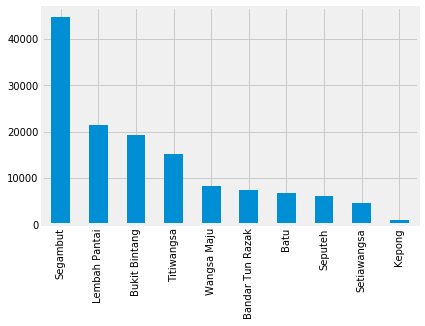

In [6]:
# Get a sense of the distribution
df_sale_klDistrict['district_master'].value_counts().plot(kind='bar')

In [7]:
# Filter for Highrises only
df_sale_klDistrict = df_sale_klDistrict[df_sale_klDistrict['Type'] == 'Condominium'].copy()

In [8]:
df_sale_klDistrict

Unnamed: 0         Type                         Location  \
6               49  Condominium               TTDI, Kuala Lumpur   
7               53  Condominium                              NaN   
29             206  Condominium        Setiawangsa, Kuala Lumpur   
65             474  Condominium            Keramat, Kuala Lumpur   
71             609  Condominium                              NaN   
72             611  Condominium                              NaN   
75             634  Condominium      Kenny Heights, Kuala Lumpur   
96             842  Condominium                              NaN   
130           1172  Condominium      Kenny Heights, Kuala Lumpur   
135           1307  Condominium  Damansara Heights, Kuala Lumpur   
136           1310  Condominium                              NaN   
181           1726  Condominium  Damansara Heights, Kuala Lumpur   
189           1814  Condominium         Taman Desa, Kuala Lumpur   
206           2028  Condominium               TTDI, Kuala Lumpur   
237           2376  Condominium                              NaN   
238           2385  Condominium                              NaN   
249           2546  Condominium                              NaN   
305           3025  Condominium             Pantai, Kuala Lumpur   
319           3205  Condominium                              NaN   
328           3275  Condominium                              NaN   
330           3287  Condominium            Keramat, Kuala Lumpur   
341           3406  Condominium                              NaN   
342           3407  Condominium      Kenny Heights, Kuala Lumpur   
344           3417  Condominium                              NaN   
347           3445  Condominium                              NaN   
361           3550  Condominium                              NaN   
366           3594  Condominium            Keramat, Kuala Lumpur   
370           3663  Condominium            Keramat, Kuala Lumpur   
376           3746  Condominium                              NaN   
389           3871  Condominium                              NaN   
...            ...          ...                              ...   
559597     4487941  Condominium                              NaN   
559598     4487942  Condominium                              NaN   
559600     4487950  Condominium                              NaN   
559602     4487997  Condominium                              NaN   
559604     4488037  Condominium       Petronas Twin Towers, KLCC   
559605     4488085  Condominium                              NaN   
559606     4488088  Condominium                              NaN   
559610     4488125  Condominium                              NaN   
559613     4488153  Condominium                              NaN   
559619     4488213  Condominium            Wisma Nusantara, KLCC   
559620     4488229  Condominium                   Avenue K, KLCC   
559621     4488233  Condominium                              NaN   
559622     4488234  Condominium                              NaN   
559623     4488270  Condominium                              NaN   
559624     4488279  Condominium                              NaN   
559626     4488302  Condominium                              NaN   
559631     4488354  Condominium                              NaN   
559633     4488398  Condominium                              NaN   
559634     4488414  Condominium                              NaN   
559643     4488502  Condominium                              NaN   
559644     4488526  Condominium                              NaN   
559645     4488531  Condominium                              NaN   
559646     4488542  Condominium                              NaN   
559647     4488562  Condominium                              NaN   
559650     4488587  Condominium                              NaN   
559654     4488634  Condominium            Wisma Nusantara, KLCC   
559655     4488635  Condominium            Wisma Nusantara, KLCC

### 3.Breakdown by the cost of property listing. Obtain the threshold by comparing to income level / external sources

We found this on Housing Watch:

![Housing Affordability](../references/Max housing affordability.png)


Let's split into B40, M40, and U20. Based on this split, we can get an estimated price range of 'low-cost','middle-cost','high-cost' housing:

- Low : < RM 300 000
- Mid : RM 300 001 - 650 000
- High: RM >650 000

In [9]:
# Split listing based on the Cost
bins = [0, 300000, 650000 ]
df_sale_klDistrict['price_bins'] =  np.searchsorted(bins, df_sale_klDistrict['price'].values)

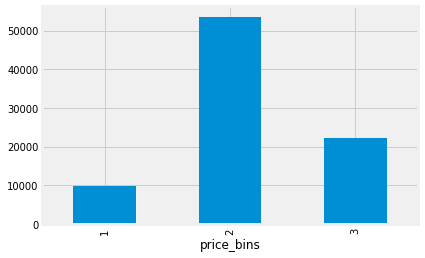

In [10]:
# Quick inspection of State-level breakdown
# 1 is Low, 2 is Mid, 3 is High
df_sale_klDistrict.groupby('price_bins').count()['Type'].plot(kind='bar')

### 4.Find the number of property listing in each 'basket'. This is the number of observation to be sampled in the following years.

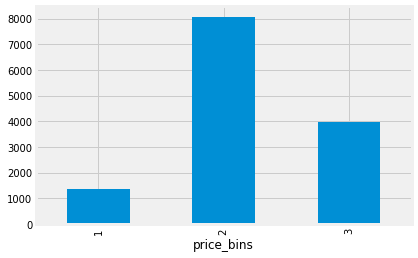

In [11]:
# Get the base year observation
df_sale_klDistrict2013 = df_sale_klDistrict[df_sale_klDistrict['year'] == 2013].copy()
df_sale_klDistrict2013.groupby('price_bins').count()['Type'].plot(kind='bar')

In [12]:
s = df_sale_klDistrict2013[df_sale_klDistrict2013['district_master'] == "Segambut"].groupby('price_bins').count()['Type']
s.sum()

4877

In [13]:
s = df_sale_klDistrict2013[df_sale_klDistrict2013['district_master'] == "Segambut"]\
                                    .groupby('price_bins')\
                                    .count()\
                                    .apply(lambda x : (x / x.sum()) * 100)['Type']
s

price_bins
1   10.293
2   63.072
3   26.635
Name: Type, dtype: float64

In [128]:
# Function to get Base year market basket proportion
# Returns a dict of district to proportion mapping
def getBaseYearBasketProportions(df_base):
    master_basketProp_dict = {}
    for district in df_base['district_master'].unique():
        count_Series = df_base[df_base['district_master'] == district].groupby('price_bins')\
                                                                        .count()\
                                                                        .apply(lambda x: (x / x.sum()) * 100)['Type']
        master_basketProp_dict[district] = {'low' : count_Series[1], 
                                            'mid': count_Series[2], 
                                            'high':count_Series[3]}
    return master_basketProp_dict

def getBaseYearBasket(df_base, population_count):
    master_basketProp_dict = {}
    for district in df_base['district_master'].unique():
        count_Series = df_base[df_base['district_master'] == district].groupby('price_bins')\
                                                                        .count()\
                                                                        .apply(lambda x: (x / population_count))['Type']
        master_basketProp_dict[district] = {'low' : count_Series[1], 
                                            'mid': count_Series[2], 
                                            'high':count_Series[3]}
    return master_basketProp_dict

In [129]:
# master_basketProp_dict = getBaseYearBasketProportions(df_sale_klDistrict2013)
master_basket_dict = getBaseYearBasket(df_sale_klDistrict2013, len(df_sale_klDistrict2013))

In [130]:
master_basket_dict

{'Bandar Tun Razak': {'high': 0.0084265473527218495,
  'low': 0.0075316927665920958,
  'mid': 0.035421327367636091},
 'Batu': {'high': 0.028859060402684565,
  'low': 0.0088739746457867259,
  'mid': 0.042281879194630875},
 'Bukit Bintang': {'high': 0.024832214765100672,
  'low': 0.015436241610738255,
  'mid': 0.094780014914243108},
 'Kepong': {'high': 0.00089485458612975394,
  'low': 0.00022371364653243848,
  'mid': 0.0031319910514541389},
 'Lembah Pantai': {'high': 0.030275913497390009,
  'low': 0.0094705443698732284,
  'mid': 0.08232662192393736},
 'Segambut': {'high': 0.096868008948545858,
  'low': 0.037434750186428035,
  'mid': 0.22938105891126026},
 'Seputeh': {'high': 0.02371364653243848,
  'low': 0.0031319910514541389,
  'mid': 0.026174496644295303},
 'Setiawangsa': {'high': 0.018120805369127517,
  'low': 0.0040268456375838931,
  'mid': 0.010216256524981357},
 'Titiwangsa': {'high': 0.04668158090976883,
  'low': 0.0041759880686055182,
  'mid': 0.044593586875466072},
 'Wangsa Maju

In [17]:
s =df_sale_klDistrict[df_sale_klDistrict['district_master'] == 'Bandar Tun Razak'].groupby(['price_bins'])\
                                                        .count()['Type']


In [18]:
s =df_sale_klDistrict[(df_sale_klDistrict['district_master'] == 'Bandar Tun Razak') &
                     (df_sale_klDistrict['year'] == 2014)].groupby(['price_bins'])\
                                                        .count()['Type']


In [19]:
master_basketProp_dict['Bandar Tun Razak']['high']

16.400580551523948

In [20]:
from random import choices
from collections import Counter
breakdown = df_sale_klDistrict['price_bins'].unique()
weights = [master_basketProp_dict['Bandar Tun Razak'][j] for j in master_basketProp_dict['Bandar Tun Razak']]
choiceP = choices(breakdown, weights, k = s.sum())
Counter(choiceP)

Counter({1: 143, 2: 124, 3: 632})

In [26]:
def getPriceBinSampleSizes(master_basketProp_dict, breakdown):
    sample_size_bins = {}
    for district in master_basketProp_dict:
        weights = [master_basketProp_dict[district][j] for j in master_basketProp_dict[district]]
        choiceP = choices(breakdown, weights, k = s.sum())
        sample_size_bins[district] = Counter(choiceP)
    return sample_size_bins

In [27]:
sample_size_bins = getPriceBinSampleSizes(master_basketProp_dict, df_sale_klDistrict['price_bins'].unique())

In [28]:
sample_size_bins

{'Bandar Tun Razak': Counter({1: 148, 2: 134, 3: 617}),
 'Batu': Counter({1: 304, 2: 86, 3: 509}),
 'Bukit Bintang': Counter({1: 169, 2: 109, 3: 621}),
 'Kepong': Counter({1: 190, 2: 45, 3: 664}),
 'Lembah Pantai': Counter({1: 219, 2: 73, 3: 607}),
 'Segambut': Counter({1: 247, 2: 85, 3: 567}),
 'Seputeh': Counter({1: 395, 2: 49, 3: 455}),
 'Setiawangsa': Counter({1: 494, 2: 128, 3: 277}),
 'Titiwangsa': Counter({1: 446, 2: 44, 3: 409}),
 'Wangsa Maju': Counter({1: 276, 2: 153, 3: 470})}

In [35]:
df_sale_klDistrict['year'].unique()

array([2017, 2013, 2014, 2015, 2016], dtype=int64)

In [74]:
def getSampleMeanPriceByBins(df_sale_klDistrict, sample_size_bins):
    df_masterSampledPrices = pd.DataFrame()
    for district in sorted(df_sale_klDistrict['district_master'].unique()):
        for i, bins in enumerate(['low','mid','high'], 1):
            price_bin_ts = []
            for year in df_sale_klDistrict['year'].unique():
                pricesSeries = df_sale_klDistrict[(df_sale_klDistrict['district_master'] == district) &
                                                (df_sale_klDistrict['year'] == year) & 
                                               ( df_sale_klDistrict['price_bins'] == i)]['price']
                if (len(pricesSeries) == 0) :
                    price_bin_ts.append(0)
                    continue
                mean_price_sample = np.median(pricesSeries.sample(sample_size_bins[district][i], replace=True))
                price_bin_ts.append(mean_price_sample)
            df_masterSampledPrices["{}-{}".format(district, bins)] = np.array(price_bin_ts)
            
    return df_masterSampledPrices

def getSamplesByBins(df_sale_klDistrict, sample_size_bins):
    df_masterSampledPrices = pd.DataFrame()
    for district in sorted(df_sale_klDistrict['district_master'].unique()):
        for i, bins in enumerate(['low','mid','high'], 1):
            price_bin_ts = []
            for year in df_sale_klDistrict['year'].unique():
                pricesSeries = df_sale_klDistrict[(df_sale_klDistrict['district_master'] == district) &
                                                (df_sale_klDistrict['year'] == year) & 
                                               ( df_sale_klDistrict['price_bins'] == i)]['price']
                if (len(pricesSeries) == 0) :
                    price_bin_ts.append(0)
                    continue
                mean_price_sample = np.median(pricesSeries.sample(sample_size_bins[district][i], replace=True))
                price_bin_ts.append(mean_price_sample)
            df_masterSampledPrices["{}-{}".format(district, bins)] = np.array(price_bin_ts)
            
    return df_masterSampledPrices

In [56]:
df_masterSampledPrices = getSampleMeanPriceByBins(df_sale_klDistrict, sample_size_bins)

In [75]:
df_masterSampledPricesMedian = getSampleMeanPriceByBins(df_sale_klDistrict, sample_size_bins)

In [51]:
sorted(df_sale_klDistrict['year'].unique())

[2013, 2014, 2015, 2016, 2017]

In [60]:
df_masterSampledPrices

Bandar Tun Razak-low  Bandar Tun Razak-mid  Bandar Tun Razak-high  \
year                                                                      
2013           239,440.649           479,494.666            944,318.574   
2014           248,020.270           421,674.627          1,198,592.211   
2015           253,248.446           466,304.731          1,081,111.021   
2016           255,340.534           483,115.216          1,250,274.131   
2017           258,898.649           475,646.672          1,057,529.721   

        Batu-low    Batu-mid     Batu-high  Bukit Bintang-low  \
year                                                            
2013 260,748.421 491,885.453   780,649.902        262,221.657   
2014 262,664.474 492,218.605   852,186.420        258,621.302   
2015 211,903.868 470,929.186   859,777.008        277,099.834   
2016 207,842.105 468,290.686 1,054,269.984        268,327.219   
2017 250,897.039 447,904.651   854,529.986        269,122.485   

      Bukit Bintang-mid  Bukit Bintang-high  Kepong-low  Kepong-mid  \
year                                                                  
2013        444,860.862         918,616.325 277,236.842 431,622.222   
2014        422,787.963       1,016,853.301 229,321.053 414,777.778   
2015        441,631.917         971,272.076 262,894.737 378,840.889   
2016        462,109.587         958,154.063       0.000 412,768.889   
2017        447,825.688         913,184.395 279,000.000 485,261.911   

       Kepong-high  Lembah Pantai-low  Lembah Pantai-mid  Lembah Pantai-high  \
year                                                                           
2013   907,284.639        261,726.005        462,442.466       1,093,816.092   
2014 1,111,617.470        263,639.269        472,630.137       1,091,619.636   
2015   953,380.030        269,268.881        483,779.288       1,117,976.079   
2016   908,801.390        269,367.068        485,064.521       1,151,341.867   
2017   828,341.093        267,376.210        487,657.534       1,054,539.827   

      Segambut-low  Segambut-mid  Segambut-high  Seputeh-low  Seputeh-mid  \
year                                                                        
2013   270,377.113   463,797.329    934,488.370  256,913.924  493,548.571   
2014   253,811.024   470,011.765    952,796.231  273,372.152  456,122.449   
2015   261,608.996   479,821.176    978,064.335  266,460.759  410,285.694   
2016   259,737.142   458,506.435    919,521.839  261,893.620  443,506.122   
2017   259,932.603   449,868.235    880,354.145  248,655.696  422,931.755   

      Seputeh-high  Setiawangsa-low  Setiawangsa-mid  Setiawangsa-high  \
year                                                                     
2013   933,734.681      260,649.798      405,143.367     1,019,007.653   
2014 1,192,929.171      231,239.879      532,656.250       968,916.968   
2015 1,049,967.277      257,921.038      456,914.570     1,045,241.877   
2016   879,862.527      249,869.605      419,707.102     1,074,862.805   
2017 1,068,467.033      252,189.607      446,044.531     1,070,711.188   

      Titiwangsa-low  Titiwangsa-mid  Titiwangsa-high  Wangsa Maju-low  \
year                                                                     
2013     245,417.049     499,500.000    1,133,561.797      261,293.029   
2014     270,697.758     518,874.727    1,200,180.147      250,416.667   
2015     237,214.083     542,385.341    1,265,070.115      273,372.043   
2016     247,320.179     507,090.909    1,278,921.472      269,393.837   
2017     246,948.628     518,990.909    1,149,714.978      269,007.246   

      Wangsa Maju-mid  Wangsa Maju-high  
year                                     
2013      475,502.366     1,132,159.574  
2014      466,198.614     1,347,080.060  
2015      474,495.582     1,277,365.240  
2016      460,497.301     1,066,661.698  
2017      494,612.732       850,362.877

In [58]:
df_masterSampledPrices['year'] = np.array([2013, 2014, 2015, 2016, 2017])
df_masterSampledPrices.set_index('year',inplace=True)

In [68]:
df_masterSampledPrices['Kepong-low'] =df_masterSampledPrices['Kepong-low'].replace(to_replace=0, method='ffill')

In [69]:
df_masterSampledPrices

Bandar Tun Razak-low  Bandar Tun Razak-mid  Bandar Tun Razak-high  \
year                                                                      
2013           239,440.649           479,494.666            944,318.574   
2014           248,020.270           421,674.627          1,198,592.211   
2015           253,248.446           466,304.731          1,081,111.021   
2016           255,340.534           483,115.216          1,250,274.131   
2017           258,898.649           475,646.672          1,057,529.721   

        Batu-low    Batu-mid     Batu-high  Bukit Bintang-low  \
year                                                            
2013 260,748.421 491,885.453   780,649.902        262,221.657   
2014 262,664.474 492,218.605   852,186.420        258,621.302   
2015 211,903.868 470,929.186   859,777.008        277,099.834   
2016 207,842.105 468,290.686 1,054,269.984        268,327.219   
2017 250,897.039 447,904.651   854,529.986        269,122.485   

      Bukit Bintang-mid  Bukit Bintang-high  Kepong-low  Kepong-mid  \
year                                                                  
2013        444,860.862         918,616.325 277,236.842 431,622.222   
2014        422,787.963       1,016,853.301 229,321.053 414,777.778   
2015        441,631.917         971,272.076 262,894.737 378,840.889   
2016        462,109.587         958,154.063 262,894.737 412,768.889   
2017        447,825.688         913,184.395 279,000.000 485,261.911   

       Kepong-high  Lembah Pantai-low  Lembah Pantai-mid  Lembah Pantai-high  \
year                                                                           
2013   907,284.639        261,726.005        462,442.466       1,093,816.092   
2014 1,111,617.470        263,639.269        472,630.137       1,091,619.636   
2015   953,380.030        269,268.881        483,779.288       1,117,976.079   
2016   908,801.390        269,367.068        485,064.521       1,151,341.867   
2017   828,341.093        267,376.210        487,657.534       1,054,539.827   

      Segambut-low  Segambut-mid  Segambut-high  Seputeh-low  Seputeh-mid  \
year                                                                        
2013   270,377.113   463,797.329    934,488.370  256,913.924  493,548.571   
2014   253,811.024   470,011.765    952,796.231  273,372.152  456,122.449   
2015   261,608.996   479,821.176    978,064.335  266,460.759  410,285.694   
2016   259,737.142   458,506.435    919,521.839  261,893.620  443,506.122   
2017   259,932.603   449,868.235    880,354.145  248,655.696  422,931.755   

      Seputeh-high  Setiawangsa-low  Setiawangsa-mid  Setiawangsa-high  \
year                                                                     
2013   933,734.681      260,649.798      405,143.367     1,019,007.653   
2014 1,192,929.171      231,239.879      532,656.250       968,916.968   
2015 1,049,967.277      257,921.038      456,914.570     1,045,241.877   
2016   879,862.527      249,869.605      419,707.102     1,074,862.805   
2017 1,068,467.033      252,189.607      446,044.531     1,070,711.188   

      Titiwangsa-low  Titiwangsa-mid  Titiwangsa-high  Wangsa Maju-low  \
year                                                                     
2013     245,417.049     499,500.000    1,133,561.797      261,293.029   
2014     270,697.758     518,874.727    1,200,180.147      250,416.667   
2015     237,214.083     542,385.341    1,265,070.115      273,372.043   
2016     247,320.179     507,090.909    1,278,921.472      269,393.837   
2017     246,948.628     518,990.909    1,149,714.978      269,007.246   

      Wangsa Maju-mid  Wangsa Maju-high  
year                                     
2013      475,502.366     1,132,159.574  
2014      466,198.614     1,347,080.060  
2015      474,495.582     1,277,365.240  
2016      460,497.301     1,066,661.698  
2017      494,612.732       850,362.877

In [103]:
df_masterSampledPrices.to_excel('../data/processed/PropwallSales-MeanTimeSeriesBySamplePriceBin.xlsx')
df_masterSampledPricesMedian.to_excel('../data/processed/PropwallSales-MedianTimeSeriesBySamplePriceBin.xlsx')

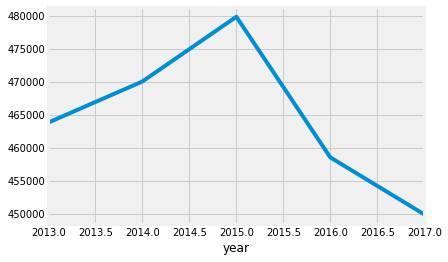

In [82]:
df_masterSampledPrices['Segambut-mid'].plot()

In [83]:
df_masterSampledPricesMedian['year'] = np.array([2013, 2014, 2015, 2016, 2017])
df_masterSampledPricesMedian.set_index('year',inplace=True)
df_masterSampledPricesMedian['Kepong-low'] =df_masterSampledPricesMedian['Kepong-low'].replace(to_replace=0, method='ffill')

In [84]:
df_masterSampledPricesMedian

Bandar Tun Razak-low  Bandar Tun Razak-mid  Bandar Tun Razak-high  \
year                                                                      
2013           267,500.000           499,000.000            730,000.000   
2014           250,000.000           386,500.000            878,000.000   
2015           258,000.000           449,999.500            882,000.000   
2016           260,000.000           480,000.000            830,000.000   
2017           266,500.000           466,500.000            830,000.000   

        Batu-low    Batu-mid   Batu-high  Bukit Bintang-low  \
year                                                          
2013 280,000.000 460,000.000 750,000.000        280,000.000   
2014 280,000.000 429,000.000 740,000.000        265,000.000   
2015 195,888.000 450,000.000 750,000.000        280,000.000   
2016 198,000.000 486,500.000 788,000.000        280,000.000   
2017 275,000.000 445,000.000 715,000.000        275,000.000   

      Bukit Bintang-mid  Bukit Bintang-high  Kepong-low  Kepong-mid  \
year                                                                  
2013        430,000.000         850,000.000 283,500.000 450,000.000   
2014        420,000.000         900,000.000 248,000.000 390,000.000   
2015        430,000.000         868,000.000 300,000.000 380,000.000   
2016        480,000.000         850,000.000 300,000.000 390,000.000   
2017        438,000.000         850,000.000 279,000.000 480,000.000   

      Kepong-high  Lembah Pantai-low  Lembah Pantai-mid  Lembah Pantai-high  \
year                                                                          
2013  822,500.000        260,000.000        448,000.000       1,050,000.000   
2014  844,000.000        270,000.000        498,000.000         843,000.000   
2015  880,000.000        280,000.000        470,000.000         950,000.000   
2016  900,000.000        278,888.000        459,000.000       1,070,000.000   
2017  846,000.000        280,000.000        455,000.000       1,030,000.000   

      Segambut-low  Segambut-mid  Segambut-high  Seputeh-low  Seputeh-mid  \
year                                                                        
2013   280,000.000   450,000.000    788,000.000  280,000.000  490,000.000   
2014   260,000.000   440,000.000    790,000.000  280,000.000  398,500.000   
2015   260,000.000   450,000.000    839,000.000  280,000.000  400,000.000   
2016   260,000.000   471,968.000    790,000.000  285,000.000  410,000.000   
2017   270,000.000   430,000.000    800,000.000  260,000.000  405,000.000   

      Seputeh-high  Setiawangsa-low  Setiawangsa-mid  Setiawangsa-high  \
year                                                                     
2013   750,000.000      280,000.000      357,500.000     1,000,000.000   
2014   850,000.000      235,000.000      600,000.000       880,000.000   
2015   768,000.000      270,000.000      462,500.000       860,000.000   
2016   740,250.000      250,000.000      410,000.000       890,000.000   
2017   760,000.000      255,000.000      417,500.000       850,000.000   

      Titiwangsa-low  Titiwangsa-mid  Titiwangsa-high  Wangsa Maju-low  \
year                                                                     
2013     258,000.000     553,460.000      883,000.000      265,000.000   
2014     280,000.000     550,000.000      819,000.000      250,000.000   
2015     250,000.000     599,500.000    1,006,499.000      280,000.000   
2016     255,000.000     577,999.500    1,100,000.000      270,000.000   
2017     255,000.000     575,000.000      950,000.000      270,000.000   

      Wangsa Maju-mid  Wangsa Maju-high  
year                                     
2013      465,000.000       750,000.000  
2014      470,000.000     1,400,000.000  
2015      478,014.000       815,000.000  
2016      435,000.000       750,000.000  
2017      480,000.000       720,000.000

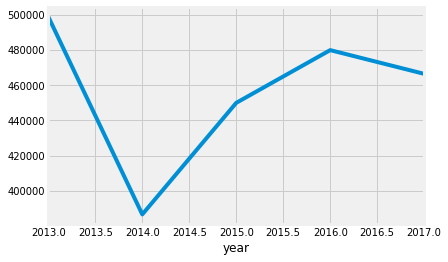

In [86]:
df_masterSampledPricesMedian['Bandar Tun Razak-mid'].plot()

In [164]:
def plotPriceBinsByDistrict(district, df):
    for bins in ['low', 'mid', 'high']:
        df["{}-{}".format(district, bins)].plot()
    plt.legend()
    
def plotPriceBinsByRange(priceRange, df, districts):
    for district in districts:
        df["{}-{}".format(district, priceRange)].plot()
    plt.legend()

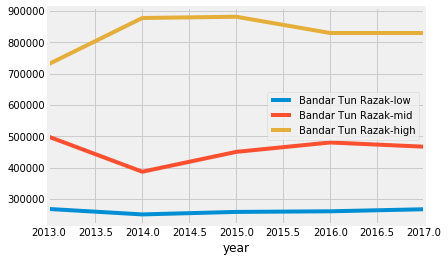

In [90]:
plotPriceBinsByDistrict('Bandar Tun Razak', df_masterSampledPricesMedian)

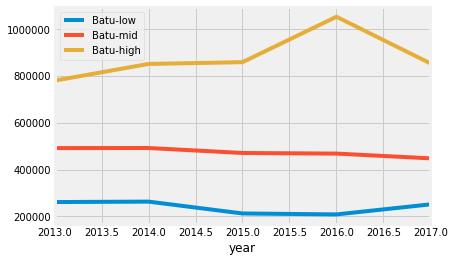

In [95]:
plotPriceBinsByDistrict('Batu', df_masterSampledPrices)

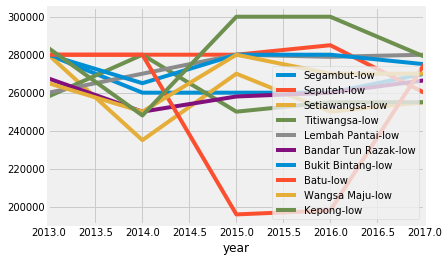

In [102]:
plotPriceBinsByRange('low', df_masterSampledPricesMedian, df_sale_klDistrict['district_master'].unique())

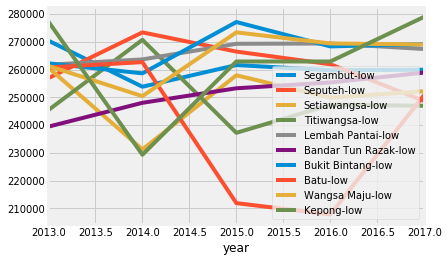

In [104]:
plotPriceBinsByRange('low', df_masterSampledPrices, df_sale_klDistrict['district_master'].unique())

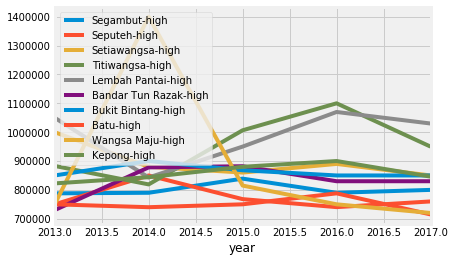

In [165]:
plotPriceBinsByRange('high', df_masterSampledPricesMedian, df_sale_klDistrict['district_master'].unique())

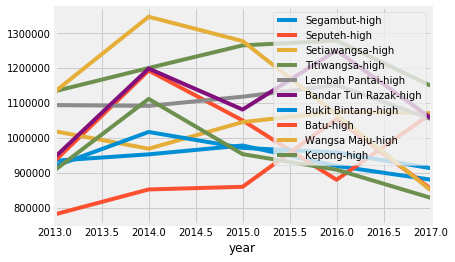

In [166]:
plotPriceBinsByRange('high', df_masterSampledPrices, df_sale_klDistrict['district_master'].unique())

In [150]:
def getStateLevelPrice(df, districts, weights_dict):
    price_series = []
    for district in districts:
        for i , priceBin in enumerate(['low','mid','high'], 1):
            price_DistrictBin = df['{}-{}'.format(district, priceBin)]\
                                .apply(lambda x : x * weights_dict[district][priceBin])
            price_series.append(price_DistrictBin)
    price_series = pd.DataFrame(price_series)
    
    time_series = []
    for i in price_series.columns:
        time_series.append(price_series[i].sum())
    return time_series

In [151]:
s = getStateLevelPrice(df_masterSampledPrices, df_sale_klDistrict['district_master'].unique(), master_basket_dict)

In [149]:
s[2013].sum()

599747.0322599451

In [155]:
df_masterSampledPrices['KL-Price'] = getStateLevelPrice(df_masterSampledPrices, df_sale_klDistrict['district_master'].unique(), master_basket_dict)
df_masterSampledPricesMedian['KL-Price'] = getStateLevelPrice(df_masterSampledPricesMedian, df_sale_klDistrict['district_master'].unique(), master_basket_dict)

In [154]:
df_masterSampledPrices

Bandar Tun Razak-low  Bandar Tun Razak-mid  Bandar Tun Razak-high  \
year                                                                      
2013           239,440.649           479,494.666            944,318.574   
2014           248,020.270           421,674.627          1,198,592.211   
2015           253,248.446           466,304.731          1,081,111.021   
2016           255,340.534           483,115.216          1,250,274.131   
2017           258,898.649           475,646.672          1,057,529.721   

        Batu-low    Batu-mid     Batu-high  Bukit Bintang-low  \
year                                                            
2013 260,748.421 491,885.453   780,649.902        262,221.657   
2014 262,664.474 492,218.605   852,186.420        258,621.302   
2015 211,903.868 470,929.186   859,777.008        277,099.834   
2016 207,842.105 468,290.686 1,054,269.984        268,327.219   
2017 250,897.039 447,904.651   854,529.986        269,122.485   

      Bukit Bintang-mid  Bukit Bintang-high  Kepong-low  Kepong-mid  \
year                                                                  
2013        444,860.862         918,616.325 277,236.842 431,622.222   
2014        422,787.963       1,016,853.301 229,321.053 414,777.778   
2015        441,631.917         971,272.076 262,894.737 378,840.889   
2016        462,109.587         958,154.063 262,894.737 412,768.889   
2017        447,825.688         913,184.395 279,000.000 485,261.911   

       Kepong-high  Lembah Pantai-low  Lembah Pantai-mid  Lembah Pantai-high  \
year                                                                           
2013   907,284.639        261,726.005        462,442.466       1,093,816.092   
2014 1,111,617.470        263,639.269        472,630.137       1,091,619.636   
2015   953,380.030        269,268.881        483,779.288       1,117,976.079   
2016   908,801.390        269,367.068        485,064.521       1,151,341.867   
2017   828,341.093        267,376.210        487,657.534       1,054,539.827   

      Segambut-low  Segambut-mid  Segambut-high  Seputeh-low  Seputeh-mid  \
year                                                                        
2013   270,377.113   463,797.329    934,488.370  256,913.924  493,548.571   
2014   253,811.024   470,011.765    952,796.231  273,372.152  456,122.449   
2015   261,608.996   479,821.176    978,064.335  266,460.759  410,285.694   
2016   259,737.142   458,506.435    919,521.839  261,893.620  443,506.122   
2017   259,932.603   449,868.235    880,354.145  248,655.696  422,931.755   

      Seputeh-high  Setiawangsa-low  Setiawangsa-mid  Setiawangsa-high  \
year                                                                     
2013   933,734.681      260,649.798      405,143.367     1,019,007.653   
2014 1,192,929.171      231,239.879      532,656.250       968,916.968   
2015 1,049,967.277      257,921.038      456,914.570     1,045,241.877   
2016   879,862.527      249,869.605      419,707.102     1,074,862.805   
2017 1,068,467.033      252,189.607      446,044.531     1,070,711.188   

      Titiwangsa-low  Titiwangsa-mid  Titiwangsa-high  Wangsa Maju-low  \
year                                                                     
2013     245,417.049     499,500.000    1,133,561.797      261,293.029   
2014     270,697.758     518,874.727    1,200,180.147      250,416.667   
2015     237,214.083     542,385.341    1,265,070.115      273,372.043   
2016     247,320.179     507,090.909    1,278,921.472      269,393.837   
2017     246,948.628     518,990.909    1,149,714.978      269,007.246   

      Wangsa Maju-mid  Wangsa Maju-high    KL-Price  
year                                                 
2013      475,502.366     1,132,159.574 599,747.032  
2014      466,198.614     1,347,080.060 618,919.313  
2015      474,495.582     1,277,365.240 625,143.932  
2016      460,497.301     1,066,661.698 616,317.974  
2017      494,612.732       850,362.877 593,115.276

In [156]:
df_masterSampledPricesMedian

Bandar Tun Razak-low  Bandar Tun Razak-mid  Bandar Tun Razak-high  \
year                                                                      
2013           267,500.000           499,000.000            730,000.000   
2014           250,000.000           386,500.000            878,000.000   
2015           258,000.000           449,999.500            882,000.000   
2016           260,000.000           480,000.000            830,000.000   
2017           266,500.000           466,500.000            830,000.000   

        Batu-low    Batu-mid   Batu-high  Bukit Bintang-low  \
year                                                          
2013 280,000.000 460,000.000 750,000.000        280,000.000   
2014 280,000.000 429,000.000 740,000.000        265,000.000   
2015 195,888.000 450,000.000 750,000.000        280,000.000   
2016 198,000.000 486,500.000 788,000.000        280,000.000   
2017 275,000.000 445,000.000 715,000.000        275,000.000   

      Bukit Bintang-mid  Bukit Bintang-high  Kepong-low  Kepong-mid  \
year                                                                  
2013        430,000.000         850,000.000 283,500.000 450,000.000   
2014        420,000.000         900,000.000 248,000.000 390,000.000   
2015        430,000.000         868,000.000 300,000.000 380,000.000   
2016        480,000.000         850,000.000 300,000.000 390,000.000   
2017        438,000.000         850,000.000 279,000.000 480,000.000   

      Kepong-high  Lembah Pantai-low  Lembah Pantai-mid  Lembah Pantai-high  \
year                                                                          
2013  822,500.000        260,000.000        448,000.000       1,050,000.000   
2014  844,000.000        270,000.000        498,000.000         843,000.000   
2015  880,000.000        280,000.000        470,000.000         950,000.000   
2016  900,000.000        278,888.000        459,000.000       1,070,000.000   
2017  846,000.000        280,000.000        455,000.000       1,030,000.000   

      Segambut-low  Segambut-mid  Segambut-high  Seputeh-low  Seputeh-mid  \
year                                                                        
2013   280,000.000   450,000.000    788,000.000  280,000.000  490,000.000   
2014   260,000.000   440,000.000    790,000.000  280,000.000  398,500.000   
2015   260,000.000   450,000.000    839,000.000  280,000.000  400,000.000   
2016   260,000.000   471,968.000    790,000.000  285,000.000  410,000.000   
2017   270,000.000   430,000.000    800,000.000  260,000.000  405,000.000   

      Seputeh-high  Setiawangsa-low  Setiawangsa-mid  Setiawangsa-high  \
year                                                                     
2013   750,000.000      280,000.000      357,500.000     1,000,000.000   
2014   850,000.000      235,000.000      600,000.000       880,000.000   
2015   768,000.000      270,000.000      462,500.000       860,000.000   
2016   740,250.000      250,000.000      410,000.000       890,000.000   
2017   760,000.000      255,000.000      417,500.000       850,000.000   

      Titiwangsa-low  Titiwangsa-mid  Titiwangsa-high  Wangsa Maju-low  \
year                                                                     
2013     258,000.000     553,460.000      883,000.000      265,000.000   
2014     280,000.000     550,000.000      819,000.000      250,000.000   
2015     250,000.000     599,500.000    1,006,499.000      280,000.000   
2016     255,000.000     577,999.500    1,100,000.000      270,000.000   
2017     255,000.000     575,000.000      950,000.000      270,000.000   

      Wangsa Maju-mid  Wangsa Maju-high    KL-Price  
year                                                 
2013      465,000.000       750,000.000 552,626.367  
2014      470,000.000     1,400,000.000 552,258.688  
2015      478,014.000       815,000.000 560,532.778  
2016      435,000.000       750,000.000 571,408.281  
2017      480,000.000       720,000.000 547,593.102

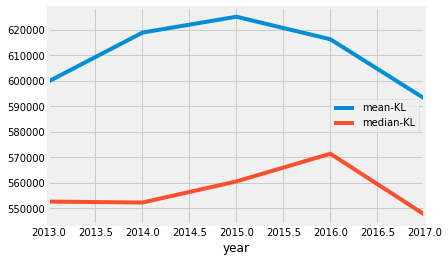

In [158]:
df_masterSampledPrices['KL-Price'].plot()
df_masterSampledPricesMedian['KL-Price'].plot()
plt.legend(['mean-KL', 'median-KL'])